# Classification using Decision Tree
## Goal
 - Tune hyperparameters for Decision Tree model

##  Conclusion
 - Final model has fairly high accuracy (0.91 for training and 0.91 for test)
 - Final model has decent recall (0.82 for training and 0.82 for test)
 - Precision on final model is ok (0.66 for training and 0.66 for test)

In [1]:
# Standard Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Models
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Transformers
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from imblearn.over_sampling import SMOTE

# Model Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, f1_score, precision_score, recall_score

# Pipelines
from imblearn.pipeline import Pipeline

### Import Data

In [2]:
df = pd.read_csv('../../data/processed/churn_dataset.csv', index_col = 0)
X = df.drop(columns = 'churn')
y = df.churn

random_state = 45
cv = 5

### Calculate baseline F1-Score

In [3]:
X_train_all, X_hold_out, y_train_all, y_hold_out = train_test_split(X, y, random_state = random_state)
number_selector = make_column_selector(dtype_include='number')
string_selector = make_column_selector(dtype_include='object')
preprocessing = make_column_transformer((OneHotEncoder(handle_unknown='ignore'), string_selector),
                                        (StandardScaler(), number_selector),
                                        remainder='passthrough')
tree = DecisionTreeClassifier(random_state = random_state)
pipeline = Pipeline([('preprocessing', preprocessing),
                     ('sm', SMOTE(random_state = random_state)), 
                     ('dt', tree)])
pipeline.fit(X_train_all, y_train_all)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa083440790>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa07f18c250>)])),
                ('sm', SMOTE(random_state=45)),
                ('dt', DecisionTreeClassifier(random_state=45))])

In [4]:
train_preds = pipeline.predict(X_train_all)
hold_out_preds = pipeline.predict(X_hold_out)

train_f1 = f1_score(y_train_all, train_preds)
test_f1 = f1_score(y_hold_out, hold_out_preds)
print('Baseline Training F1-Score: {:.2f}'.format(train_f1))
print('Baseline Testing F1-Score: {:.2f}'.format(test_f1))

Baseline Training F1-Score: 1.00
Baseline Testing F1-Score: 0.70


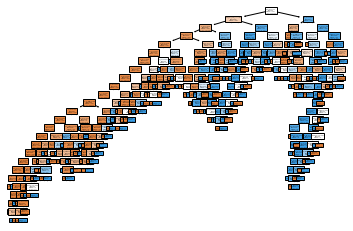

In [5]:
categoricals = list(preprocessing.transformers_[0][1].get_feature_names())
scaled = preprocessing.transformers_[1][2]
feature_names = categoricals + scaled
plot_tree(pipeline.steps[-1][1], feature_names = feature_names, filled = True);

### Tune Hyperparameters
***First Round:***
- Include wide range of values

In [6]:
param_grid = {'dt__criterion':('gini', 'entropy'),
              'dt__splitter':('best', 'random'),
              'dt__max_depth':[5, 10, 15],
              'dt__min_samples_split':[25, 50, 75, 100],
              'dt__min_samples_leaf':[25, 50],
              'dt__max_leaf_nodes':[5, 10, 15, 20, 25]}
grid_search = GridSearchCV(pipeline, param_grid, scoring = 'f1')
grid_search.fit(X_train_all, y_train_all)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fa083440790>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fa07f18c250>)])),
                                       ('sm', SMOTE(random_state=45)),
                                       ('dt',
                                     

In [7]:
print('Training F1-Score: {:.2f}'.format(grid_search.score(X_train_all, y_train_all)))
print('Test F1-Score: {:.2f}'.format(grid_search.score(X_hold_out, y_hold_out)))

Training F1-Score: 0.66
Test F1-Score: 0.64


In [8]:
grid_search.best_params_

{'dt__criterion': 'entropy',
 'dt__max_depth': 10,
 'dt__max_leaf_nodes': 20,
 'dt__min_samples_leaf': 50,
 'dt__min_samples_split': 25,
 'dt__splitter': 'best'}

***Since min_samples_split < min_samples_leaf, it does not have an effect on the model and will be dropped***

In [9]:
tree = DecisionTreeClassifier(random_state = random_state,
                             criterion = 'entropy', max_depth = 10,
                             max_leaf_nodes = 20, min_samples_leaf = 50,
                             splitter = 'best')
pipeline = Pipeline([('preprocessing', preprocessing),
                     ('sm', SMOTE(random_state = random_state)), 
                     ('dt', tree)])
pipeline.fit(X_train_all, y_train_all)
train_preds = pipeline.predict(X_train_all)
hold_out_preds = pipeline.predict(X_hold_out)
train_f1 = f1_score(y_train_all, train_preds)
test_f1 = f1_score(y_hold_out, hold_out_preds)
print('Training F1-Score: {:.2f}'.format(train_f1))
print('Testing F1-Score: {:.2f}'.format(test_f1))

Training F1-Score: 0.66
Testing F1-Score: 0.64


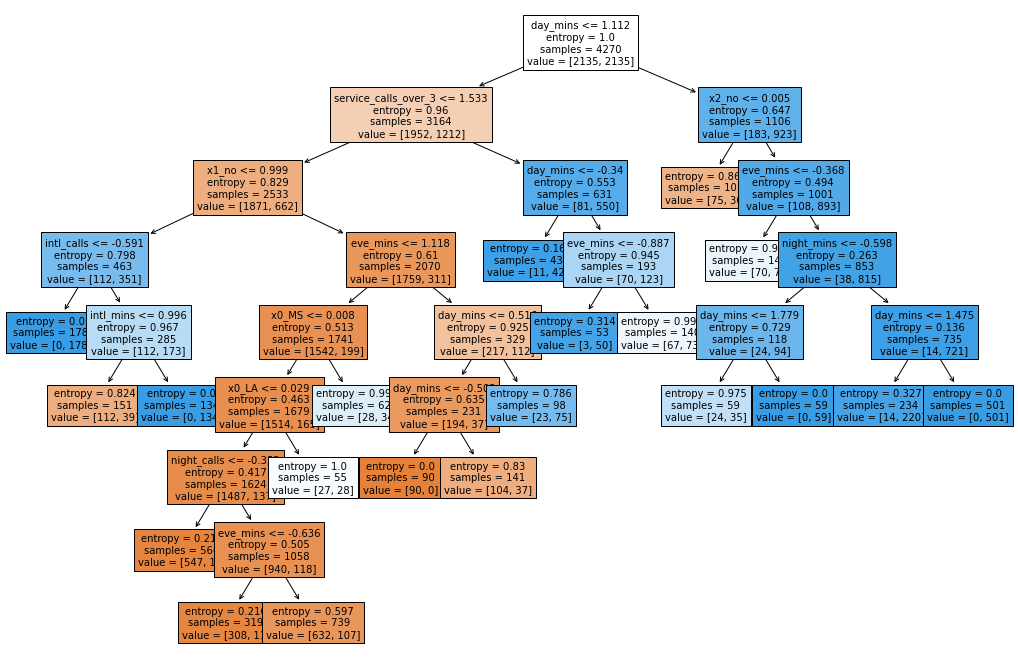

In [10]:
plt.figure(figsize = (18, 12))
plot_tree(pipeline.steps[-1][1], feature_names = feature_names, filled = True, fontsize = 10);

***Second Round:***
- Drop min_samples_split
- Reduce size of tree
    - Limit max_depth to 5
    - Limit max_samples_leaf to 25 or 59
    - Limit max_leaf_node to 10 or 15

In [11]:
param_grid = {'dt__criterion':('gini', 'entropy'),
              'dt__splitter':('best', 'random'),
              'dt__max_depth':[5],
              'dt__min_samples_leaf':[25, 50],
              'dt__max_leaf_nodes':[10, 15]}
grid_search = GridSearchCV(pipeline, param_grid, scoring = 'f1')
grid_search.fit(X_train_all, y_train_all)

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fa083440790>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fa07f18c250>)])),
                                       ('sm', SMOTE(random_state=45)),
                                       ('dt',
                                     

In [12]:
print('Training F1-Score: {:.2f}'.format(grid_search.score(X_train_all, y_train_all)))
print('Test F1-Score: {:.2f}'.format(grid_search.score(X_hold_out, y_hold_out)))

Training F1-Score: 0.73
Test F1-Score: 0.73


In [13]:
grid_search.best_params_

{'dt__criterion': 'gini',
 'dt__max_depth': 5,
 'dt__max_leaf_nodes': 15,
 'dt__min_samples_leaf': 50,
 'dt__splitter': 'best'}

### Instantiate final model

In [14]:
tree = DecisionTreeClassifier(random_state = random_state,
                             criterion = 'gini', max_depth = 5,
                             max_leaf_nodes = 15, min_samples_leaf = 50,
                             splitter = 'best')
pipeline = Pipeline([('preprocessing', preprocessing),
                     ('sm', SMOTE(random_state = random_state)), 
                     ('dt', tree)])
pipeline.fit(X_train_all, y_train_all)
train_preds = pipeline.predict(X_train_all)
hold_out_preds = pipeline.predict(X_hold_out)
train_f1 = f1_score(y_train_all, train_preds)
test_f1 = f1_score(y_hold_out, hold_out_preds)
print('Training F1-Score: {:.2f}'.format(train_f1))
print('Testing F1-Score: {:.2f}'.format(test_f1))

Training F1-Score: 0.73
Testing F1-Score: 0.73


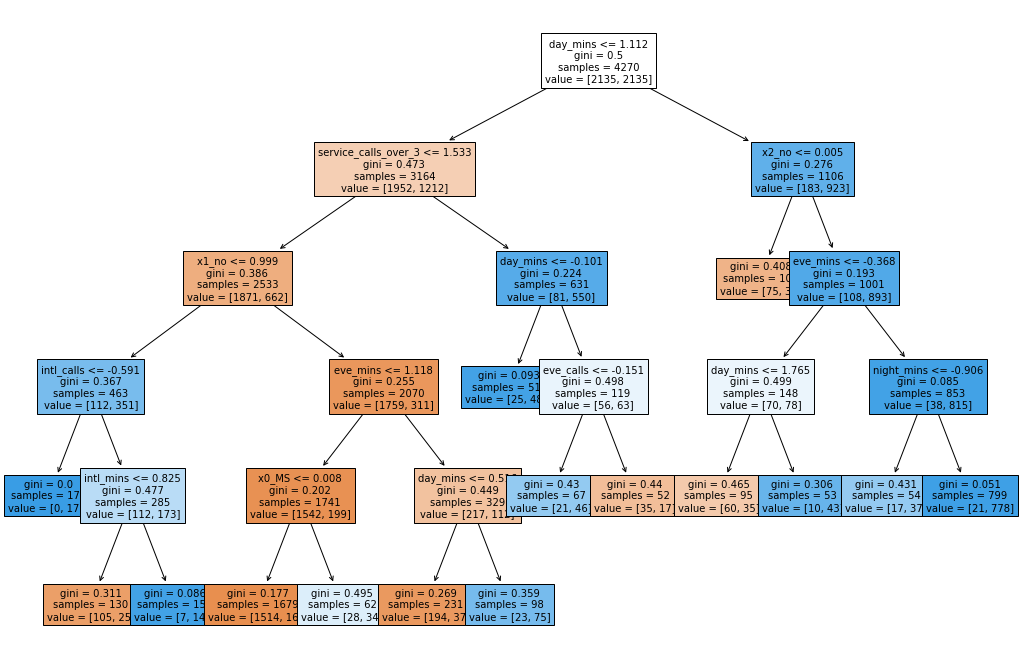

In [15]:
plt.figure(figsize = (18, 12))
plot_tree(pipeline.steps[-1][1], feature_names = feature_names, filled = True, fontsize = 10);

### Check Confusion Matrices and Calculate Accuracy

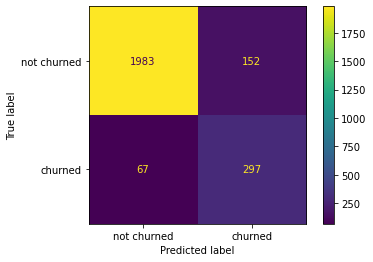

In [16]:
plot_confusion_matrix(pipeline, X_train_all, y_train_all, display_labels=['not churned', 'churned'])

In [17]:
print('Training Accuracy: {:.2f}'.format(pipeline.score(X_train_all, y_train_all)))
print('Training Recall: {:.2f}'.format(recall_score(y_train_all, train_preds)))
print('Training Precision: {:.2f}'.format(precision_score(y_train_all, train_preds)))

Training Accuracy: 0.91
Training Recall: 0.82
Training Precision: 0.66


***Notes***
- Training accuracy is fairly high
- Training recall is decent
- Training precision is ok

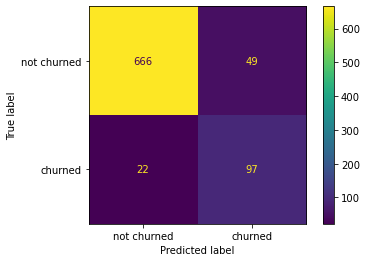

In [18]:
plot_confusion_matrix(pipeline, X_hold_out, y_hold_out, display_labels=['not churned', 'churned'])

In [19]:
print('Test Accuracy: {:.2f}'.format(pipeline.score(X_hold_out, y_hold_out)))
print('Test Recall: {:.2f}'.format(recall_score(y_hold_out, hold_out_preds)))
print('Test Precision: {:.2f}'.format(precision_score(y_hold_out, hold_out_preds)))

Test Accuracy: 0.91
Test Recall: 0.82
Test Precision: 0.66


***Notes***
- Test accuracy is fairly high
- Test recall is decent
- Test precision is ok